Increment 1 | Iteration 1 | Residual: 2.23515e+02
Increment 1 | Iteration 2 | Residual: 4.00558e+01
Increment 1 | Iteration 3 | Residual: 5.38216e-14
Increment 2 | Iteration 1 | Residual: 1.94336e-13
Increment 3 | Iteration 1 | Residual: 2.38459e-13
Increment 4 | Iteration 1 | Residual: 2.47578e-13
Increment 5 | Iteration 1 | Residual: 2.59140e-13
Increment 6 | Iteration 1 | Residual: 2.61231e-13
Increment 7 | Iteration 1 | Residual: 2.48989e-13
Increment 8 | Iteration 1 | Residual: 2.34828e-13
Increment 9 | Iteration 1 | Residual: 2.31548e-13
Increment 10 | Iteration 1 | Residual: 2.29070e-13
Increment 11 | Iteration 1 | Residual: 2.09436e-13
Increment 12 | Iteration 1 | Residual: 1.97533e-13
Increment 13 | Iteration 1 | Residual: 2.04079e-13
Increment 14 | Iteration 1 | Residual: 1.89917e-13
Increment 15 | Iteration 1 | Residual: 1.83143e-13
Increment 16 | Iteration 1 | Residual: 1.69701e-13
Increment 17 | Iteration 1 | Residual: 1.52169e-13
Increment 18 | Iteration 1 | Residual: 1.4

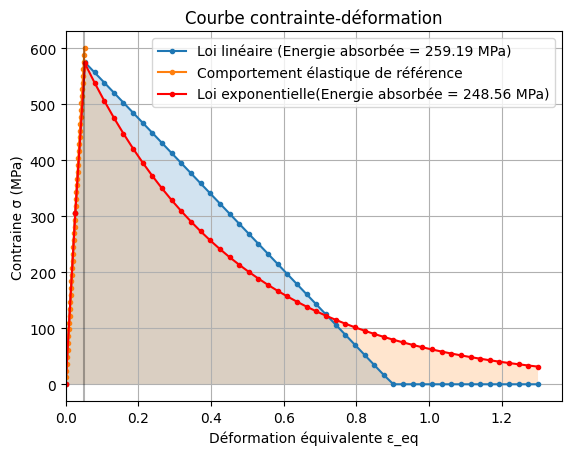

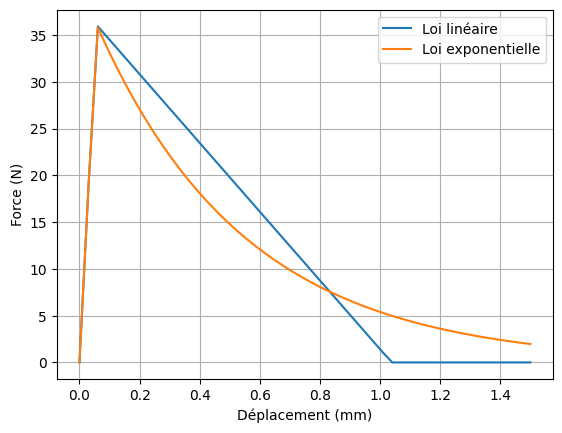

In [10]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from damage_simple import IsotropicDamage3D
from damage_simple import IsotropicElasticity3D

from torchfem.mesh import cube_hexa

import numpy as np

torch.set_default_dtype(torch.float64)

E = 10e3
nu = 0.3
eps_0=0.05

def d_kappa(kappa):

   #can compute fracture energy (cf sagepub)

   eps_f=0.9   #2*G_f/(sigma_t*size)+eps_0/2   strain total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   #evolution[kappa_d] = 1-eps_0*(eps_f-kappa[kappa_d])/(kappa[kappa_d]*(eps_f-eps_0)) ##prendre eps_0 dependant de eps_eq ou de eps_x ?????
   evolution[kappa_d] = (1-eps_0/kappa[kappa_d])*(eps_f/(eps_f-eps_0))

   kappa_max=kappa>=eps_f
   evolution[kappa_max] = 1

   return evolution


def d_kappa_exp(kappa):

   eps_e=0.48    #2*G_f/(sigma_t*size)+eps_0/2     controls shape of curve =! of epsilon total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   evolution[kappa_d] = 1-eps_0/kappa[kappa_d]*torch.exp(-(kappa[kappa_d]-eps_0)/(eps_e-eps_0))     

   return evolution


def Compute_VM(epsilon):

      trace_eps = epsilon[..., 0, 0] + epsilon[..., 1, 1] + epsilon[..., 2, 2]
      dev_eps=epsilon.clone()
      dev_eps[..., 0, 0] -= trace_eps / 3
      dev_eps[..., 1, 1] -= trace_eps / 3
      dev_eps[..., 2, 2] -= trace_eps / 3

      eps_von_m= torch.sqrt(2/3 * torch.sum(dev_eps * dev_eps, dim=(-1, -2)))

      return eps_von_m

# Elastic properties
material = IsotropicDamage3D(E, nu, d_kappa)
material_exp = IsotropicDamage3D(E, nu, d_kappa_exp)
material1 = IsotropicElasticity3D(E,nu)

# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

box = Solid(nodes, elements, material)
box2=Solid(nodes,elements,material1)
box3=Solid(nodes,elements,material_exp)

# Set constraints
DL = 5
box.displacements[nodes[:, 0] == 1.0, 0] = DL
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

DL2=0.20
box2.displacements[nodes[:, 0] == 1.0, 0] = DL2
box2.constraints[nodes[:, 0] == 0.0, 0] = True
box2.constraints[nodes[:, 0] == 1.0, 0] = True
box2.constraints[nodes[:, 1] == 0.5, 1] = True
box2.constraints[nodes[:, 2] == 0.5, 2] = True

DL = 5
box3.displacements[nodes[:, 0] == 1.0, 0] = DL
box3.constraints[nodes[:, 0] == 0.0, 0] = True
box3.constraints[nodes[:, 0] == 1.0, 0] = True
box3.constraints[nodes[:, 1] == 0.5, 1] = True
box3.constraints[nodes[:, 2] == 0.5, 2] = True

# Incremental loading
increments = torch.linspace(0.0, 0.3, 50)

#increments = torch.cat((torch.linspace(0.0, 0.48, 50), torch.linspace(0.5, 0.0, 51),torch.linspace(0.0, 1.1, 59),torch.linspace(1.08, 0.0, 58)))
u, f, σ, F, α = box.solve(increments=increments, return_intermediate=True, verbose=True) ####direct ?????
u1, f1, σ1, F1, α1 = box2.solve(increments=increments, return_intermediate=True)
u2, f2, σ2, F2, α2 = box3.solve(increments=increments, return_intermediate=True, verbose=True)


# Average x components over elements
ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(3)

strain=Compute_VM(ε).mean(dim=1)

#strain = ε[:, :, 0, 0].mean(dim=1)
stress = σ[:, :, 0, 0].mean(dim=1)
D = α.mean(dim=1)

ε1 = 0.5 * (F1.transpose(-1, -2) + F1) - torch.eye(3)

strain1=Compute_VM(ε1).mean(dim=1)

#strain1 = ε1[:, :, 0, 0].mean(dim=1)
stress1 = σ1[:, :, 0, 0].mean(dim=1)

ε2 = 0.5 * (F2.transpose(-1, -2) + F2) - torch.eye(3)
strain2=Compute_VM(ε2).mean(dim=1)

#strain2 = ε2[:, :, 0, 0].mean(dim=1)
stress2 = σ2[:, :, 0, 0].mean(dim=1)

#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")

ref_strain=[0,eps_0,0.9]
ref_stress=[0,E*eps_0,0]


# Calcul des aires sous chaque courbe en MPa
aire1 = np.trapezoid(stress,strain)
aire2 = np.trapezoid(stress2, strain2)



tip=(nodes[:,0]==1) &(nodes[:,1]==0.5) &(nodes[:,2]==0.5) 

plt.plot(strain, stress, ".-",label=f"Loi linéaire (Energie absorbée = {aire1:.2f} MPa)")
plt.plot(strain1, stress1, ".-", label="Comportement élastique de référence")
plt.plot(strain2, stress2, ".-",label=f"Loi exponentielle(Energie absorbée = {aire2:.2f} MPa)", color="red")
#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.fill_between(strain, stress, alpha=0.2)
plt.fill_between(strain2, stress2, alpha=0.2)
plt.axvline(eps_0, color="black", alpha=0.3)
plt.xlabel("Déformation équivalente ε_eq")
plt.ylabel("Contraine σ (MPa)")
plt.title("Courbe contrainte-déformation")
plt.xlim(left=0)
plt.grid()
plt.legend()
plt.show()

# plt.plot(strain, D, label="kappa")
# plt.plot(strain, strain,  alpha=0.3, color="black")
# plt.xlabel("Strain ε_eq")
# plt.ylabel("Kappa")
# plt.show()

plt.plot(u[:,tip,0], f[:,tip,0],label="Loi linéaire")
plt.plot(u2[:,tip,0], f2[:,tip,0],label="Loi exponentielle")
plt.xlabel("Déplacement (mm)")
plt.ylabel("Force (N)")
plt.legend()
plt.grid()
plt.show()

Increment 1 | Iteration 1 | Residual: 1.88014e+02
Increment 1 | Iteration 2 | Residual: 5.50478e+01
Increment 1 | Iteration 3 | Residual: 5.21053e-14
Increment 2 | Iteration 1 | Residual: 1.87311e-13
Increment 3 | Iteration 1 | Residual: 2.01809e-13
Increment 4 | Iteration 1 | Residual: 1.80692e-13
Increment 5 | Iteration 1 | Residual: 1.63016e-13
Increment 6 | Iteration 1 | Residual: 1.44007e-13
Increment 7 | Iteration 1 | Residual: 1.18932e-13
Increment 8 | Iteration 1 | Residual: 9.91666e-14
Increment 9 | Iteration 1 | Residual: 9.02799e-14
Increment 10 | Iteration 1 | Residual: 7.98728e-14
Increment 11 | Iteration 1 | Residual: 6.22077e-14
Increment 12 | Iteration 1 | Residual: 6.62710e-14
Increment 13 | Iteration 1 | Residual: 7.11684e-14
Increment 14 | Iteration 1 | Residual: 7.26657e-14
Increment 15 | Iteration 1 | Residual: 8.60018e-14
Increment 16 | Iteration 1 | Residual: 3.76139e-14
Increment 17 | Iteration 1 | Residual: 2.87605e-14
Increment 18 | Iteration 1 | Residual: 1.1

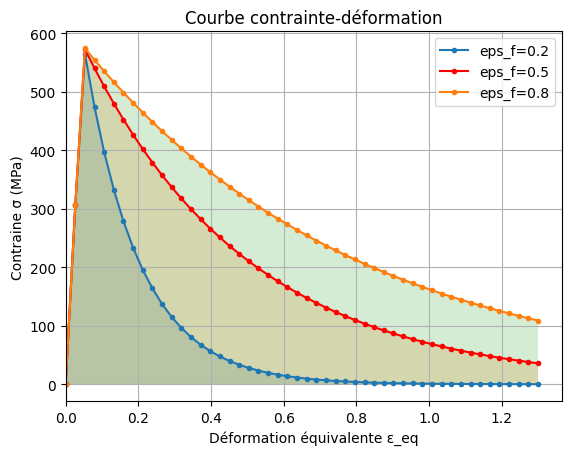

In [11]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from damage_simple import IsotropicDamage3D
from damage_simple import IsotropicElasticity3D

from torchfem.mesh import cube_hexa

import numpy as np

torch.set_default_dtype(torch.float64)

E = 10e3
nu = 0.3
eps_0=0.05

def d_kappa_exp1(kappa):

   eps_e=0.2    #2*G_f/(sigma_t*size)+eps_0/2     controls shape of curve =! of epsilon total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   evolution[kappa_d] = 1-eps_0/kappa[kappa_d]*torch.exp(-(kappa[kappa_d]-eps_0)/(eps_e-eps_0))     

   return evolution

def d_kappa_exp2(kappa):

   eps_e=0.5    #2*G_f/(sigma_t*size)+eps_0/2     controls shape of curve =! of epsilon total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   evolution[kappa_d] = 1-eps_0/kappa[kappa_d]*torch.exp(-(kappa[kappa_d]-eps_0)/(eps_e-eps_0))     

   return evolution

def d_kappa_exp3(kappa):

   eps_e=0.8    #2*G_f/(sigma_t*size)+eps_0/2     controls shape of curve =! of epsilon total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   evolution[kappa_d] = 1-eps_0/kappa[kappa_d]*torch.exp(-(kappa[kappa_d]-eps_0)/(eps_e-eps_0))     

   return evolution

def Compute_VM(epsilon):

      trace_eps = epsilon[..., 0, 0] + epsilon[..., 1, 1] + epsilon[..., 2, 2]
      dev_eps=epsilon.clone()
      dev_eps[..., 0, 0] -= trace_eps / 3
      dev_eps[..., 1, 1] -= trace_eps / 3
      dev_eps[..., 2, 2] -= trace_eps / 3

      eps_von_m= torch.sqrt(2/3 * torch.sum(dev_eps * dev_eps, dim=(-1, -2)))

      return eps_von_m

# Elastic properties
material_exp1 = IsotropicDamage3D(E, nu, d_kappa_exp1)
material_exp2 = IsotropicDamage3D(E, nu, d_kappa_exp2)
material_exp3 = IsotropicDamage3D(E, nu, d_kappa_exp3)


# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

box = Solid(nodes, elements, material_exp1)
box2=Solid(nodes,elements,material_exp2)
box3=Solid(nodes,elements,material_exp3)

# Set constraints
DL = 5
box.displacements[nodes[:, 0] == 1.0, 0] = DL
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

DL2=5
box2.displacements[nodes[:, 0] == 1.0, 0] = DL2
box2.constraints[nodes[:, 0] == 0.0, 0] = True
box2.constraints[nodes[:, 0] == 1.0, 0] = True
box2.constraints[nodes[:, 1] == 0.5, 1] = True
box2.constraints[nodes[:, 2] == 0.5, 2] = True

DL = 5
box3.displacements[nodes[:, 0] == 1.0, 0] = DL
box3.constraints[nodes[:, 0] == 0.0, 0] = True
box3.constraints[nodes[:, 0] == 1.0, 0] = True
box3.constraints[nodes[:, 1] == 0.5, 1] = True
box3.constraints[nodes[:, 2] == 0.5, 2] = True

# Incremental loading
increments = torch.linspace(0.0, 0.3, 50)

#increments = torch.cat((torch.linspace(0.0, 0.98, 50), torch.linspace(1.0, 0.0, 51),torch.linspace(0.0, 1.1, 59),torch.linspace(1.08, 0.0, 58)))
u, f, σ, F, α = box.solve(increments=increments, return_intermediate=True, verbose=True) ####direct ?????
u1, f1, σ1, F1, α1 = box2.solve(increments=increments, return_intermediate=True)
u2, f2, σ2, F2, α2 = box3.solve(increments=increments, return_intermediate=True, verbose=True)


# Average x components over elements
ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(3)

strain=Compute_VM(ε).mean(dim=1)

#strain = ε[:, :, 0, 0].mean(dim=1)
stress = σ[:, :, 0, 0].mean(dim=1)
D = α.mean(dim=1)

ε1 = 0.5 * (F1.transpose(-1, -2) + F1) - torch.eye(3)

strain1=Compute_VM(ε1).mean(dim=1)

#strain1 = ε1[:, :, 0, 0].mean(dim=1)
stress1 = σ1[:, :, 0, 0].mean(dim=1)

ε2 = 0.5 * (F2.transpose(-1, -2) + F2) - torch.eye(3)
strain2=Compute_VM(ε2).mean(dim=1)

#strain2 = ε2[:, :, 0, 0].mean(dim=1)
stress2 = σ2[:, :, 0, 0].mean(dim=1)

#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")

ε2 = 0.5 * (F2.transpose(-1, -2) + F2) - torch.eye(3)
strain2=Compute_VM(ε2).mean(dim=1)

#strain2 = ε2[:, :, 0, 0].mean(dim=1)
stress2 = σ2[:, :, 0, 0].mean(dim=1)

# Calcul des aires sous chaque courbe en MPa
aire = np.trapezoid(stress,strain)
aire1 = np.trapezoid(stress1, strain1)
aire2 = np.trapezoid(stress2, strain2)



tip=(nodes[:,0]==1) &(nodes[:,1]==0.5) &(nodes[:,2]==0.5) 

plt.plot(strain, stress, ".-",label=f"eps_f=0.2")

plt.plot(strain1, stress1, ".-",label=f"eps_f=0.5", color="red")
plt.plot(strain2, stress2, ".-",label=f"eps_f=0.8")
#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.fill_between(strain, stress, alpha=0.2)
plt.fill_between(strain1, stress1, alpha=0.2)
plt.fill_between(strain2, stress2, alpha=0.2)
plt.xlabel("Déformation équivalente ε_eq")
plt.ylabel("Contraine σ (MPa)")
plt.title("Courbe contrainte-déformation")
plt.xlim(left=0)
plt.grid()
plt.legend()
plt.show()

# plt.plot(strain, D, label="kappa")
# plt.plot(strain, strain,  alpha=0.3, color="black")
# plt.xlabel("Strain ε_eq")
# plt.ylabel("Kappa")
# plt.show()

Increment 1 | Iteration 1 | Residual: 2.23961e+02
Increment 1 | Iteration 2 | Residual: 3.74290e+01
Increment 1 | Iteration 3 | Residual: 4.47005e-14
Increment 2 | Iteration 1 | Residual: 5.02636e-14
Increment 3 | Iteration 1 | Residual: 4.62456e-14
Increment 4 | Iteration 1 | Residual: 4.25980e-14
Increment 5 | Iteration 1 | Residual: 4.41375e-14
Increment 6 | Iteration 1 | Residual: 4.31539e-14
Increment 7 | Iteration 1 | Residual: 6.34366e-14
Increment 8 | Iteration 1 | Residual: 5.01354e-14
Increment 9 | Iteration 1 | Residual: 3.90785e-14
Increment 10 | Iteration 1 | Residual: 4.12169e-14
Increment 11 | Iteration 1 | Residual: 4.96324e-14
Increment 12 | Iteration 1 | Residual: 5.00116e-14
Increment 13 | Iteration 1 | Residual: 6.38709e-14
Increment 14 | Iteration 1 | Residual: 6.57405e-14
Increment 15 | Iteration 1 | Residual: 6.26256e-14
Increment 16 | Iteration 1 | Residual: 3.65119e-14
Increment 17 | Iteration 1 | Residual: 3.18932e-14
Increment 18 | Iteration 1 | Residual: 6.8

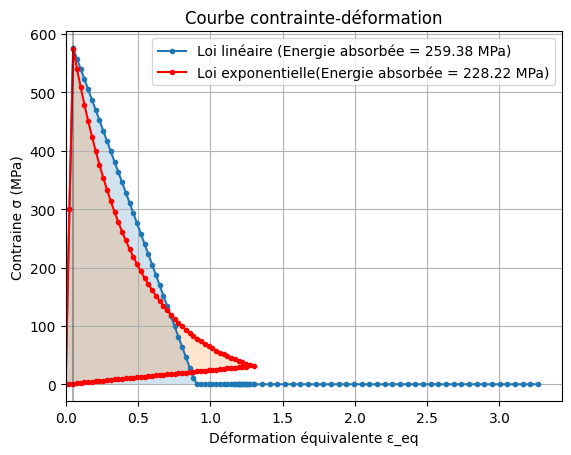

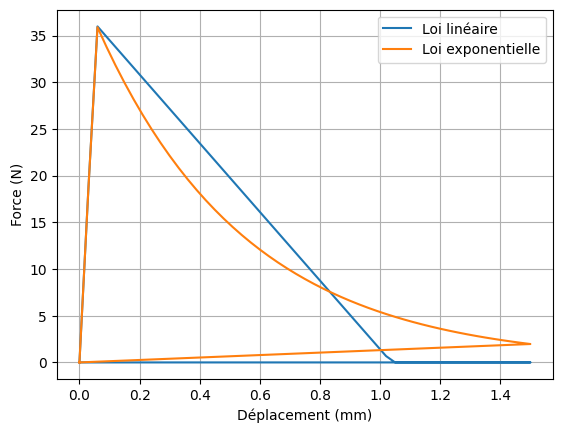

In [1]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from damage_simple import IsotropicDamage3D
from damage_simple import IsotropicElasticity3D

from torchfem.mesh import cube_hexa

import numpy as np

torch.set_default_dtype(torch.float64)

E = 10e3
nu = 0.3
eps_0=0.05

def d_kappa(kappa):

   #can compute fracture energy (cf sagepub)

   eps_f=0.9   #2*G_f/(sigma_t*size)+eps_0/2   strain total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   #evolution[kappa_d] = 1-eps_0*(eps_f-kappa[kappa_d])/(kappa[kappa_d]*(eps_f-eps_0)) ##prendre eps_0 dependant de eps_eq ou de eps_x ?????
   evolution[kappa_d] = (1-eps_0/kappa[kappa_d])*(eps_f/(eps_f-eps_0))

   kappa_max=kappa>=eps_f
   evolution[kappa_max] = 1

   return evolution


def d_kappa_exp(kappa):

   eps_e=0.48    #2*G_f/(sigma_t*size)+eps_0/2     controls shape of curve =! of epsilon total failure

   evolution = torch.zeros_like(kappa)

   kappa_d=kappa>=eps_0
   evolution[kappa_d] = 1-eps_0/kappa[kappa_d]*torch.exp(-(kappa[kappa_d]-eps_0)/(eps_e-eps_0))     

   return evolution


def Compute_VM(epsilon):

      trace_eps = epsilon[..., 0, 0] + epsilon[..., 1, 1] + epsilon[..., 2, 2]
      dev_eps=epsilon.clone()
      dev_eps[..., 0, 0] -= trace_eps / 3
      dev_eps[..., 1, 1] -= trace_eps / 3
      dev_eps[..., 2, 2] -= trace_eps / 3

      eps_von_m= torch.sqrt(2/3 * torch.sum(dev_eps * dev_eps, dim=(-1, -2)))

      return eps_von_m

# Elastic properties
material = IsotropicDamage3D(E, nu, d_kappa)
material_exp = IsotropicDamage3D(E, nu, d_kappa_exp)


# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

box = Solid(nodes, elements, material)

box3=Solid(nodes,elements,material_exp)

# Set constraints
DL = 3
box.displacements[nodes[:, 0] == 1.0, 0] = DL
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

DL = 3
box3.displacements[nodes[:, 0] == 1.0, 0] = DL
box3.constraints[nodes[:, 0] == 0.0, 0] = True
box3.constraints[nodes[:, 0] == 1.0, 0] = True
box3.constraints[nodes[:, 1] == 0.5, 1] = True
box3.constraints[nodes[:, 2] == 0.5, 2] = True

# Incremental loading
increments = torch.cat((torch.linspace(0.0, 0.5, 51), torch.linspace(0.48, 0.0, 49)))

u, f, σ, F, α = box.solve(increments=increments, return_intermediate=True, verbose=True) ####direct ?????

u2, f2, σ2, F2, α2 = box3.solve(increments=increments, return_intermediate=True, verbose=True)


# Average x components over elements
ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(3)

strain=Compute_VM(ε).mean(dim=1)

#strain = ε[:, :, 0, 0].mean(dim=1)
stress = σ[:, :, 0, 0].mean(dim=1)
D = α.mean(dim=1)

ε2 = 0.5 * (F2.transpose(-1, -2) + F2) - torch.eye(3)
strain2=Compute_VM(ε2).mean(dim=1)

#strain2 = ε2[:, :, 0, 0].mean(dim=1)
stress2 = σ2[:, :, 0, 0].mean(dim=1)

#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")


# Calcul des aires sous chaque courbe en MPa
aire1 = np.trapezoid(stress,strain)
aire2 = np.trapezoid(stress2, strain2)



tip=(nodes[:,0]==1) &(nodes[:,1]==0.5) &(nodes[:,2]==0.5) 

plt.plot(strain, stress, ".-",label=f"Loi linéaire (Energie absorbée = {aire1:.2f} MPa)")
plt.plot(strain2, stress2, ".-",label=f"Loi exponentielle(Energie absorbée = {aire2:.2f} MPa)", color="red")
#plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.fill_between(strain, stress, alpha=0.2)
plt.fill_between(strain2, stress2, alpha=0.2)
plt.axvline(eps_0, color="black", alpha=0.3)
plt.xlabel("Déformation équivalente ε_eq")
plt.ylabel("Contraine σ (MPa)")
plt.title("Courbe contrainte-déformation")
plt.xlim(left=0)
plt.grid()
plt.legend()
plt.show()

# plt.plot(strain, D, label="kappa")
# plt.plot(strain, strain,  alpha=0.3, color="black")
# plt.xlabel("Strain ε_eq")
# plt.ylabel("Kappa")
# plt.show()

plt.plot(u[:,tip,0], f[:,tip,0],label="Loi linéaire")
plt.plot(u2[:,tip,0], f2[:,tip,0],label="Loi exponentielle")
plt.xlabel("Déplacement (mm)")
plt.ylabel("Force (N)")
plt.legend()
plt.grid()
plt.show()